### 📊 Task 1 – Analyze Stock Price Evolution and Log-Returns

In this task, we:

1. **Visualize** the historical evolution of the stock price.
2. **Compute summary statistics** of the stock price:
  - Mean
  - Standard Deviation
  - Minimum / Maximum (with corresponding dates)
  - Quantiles (25%, 50%, 75%)

---

#### 📈 Log Returns

We define the log return $r_t$ at time $t$ as:

$$
r_t = \ln\left(\frac{P_{t}}{P_{t-1}}\right) = \ln(P_{t}) - \ln(P_{t-1})
$$

This transformation is useful because log returns are:
- **Time additive** over multiple periods,
- **Approximately normally distributed**, especially over short intervals.

---

We:
- **Visualize the distribution** of log returns,
- **Plot their histogram** to assess distributional features,
- **Compute key descriptive statistics**:
  - Mean
  - Standard Deviation
  - Minimum / Maximum
  - Quantiles (25%, 50%, 75%)

This statistical analysis allows us to better understand the behavior and volatility of the underlying stock returns.


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.float_format = '{:.3f}'.format  # show 3 decimals

In [73]:
data = pd.read_csv("Telekom.csv")
data.head()

,Date,Close
0,2014-06-17,12.585
1,2014-06-18,12.660
2,2014-06-19,12.800
3,2014-06-20,12.735
4,2014-06-23,12.675


In [74]:
data.dtypes

Date      object
Close    float64
dtype: object

In [75]:
data["Date"] = pd.to_datetime(data["Date"])
data.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [76]:
if len(data.columns) == 2:
    data.set_index('Date',inplace=True)
    print('Date is the new index of data')


Date is the new index of data


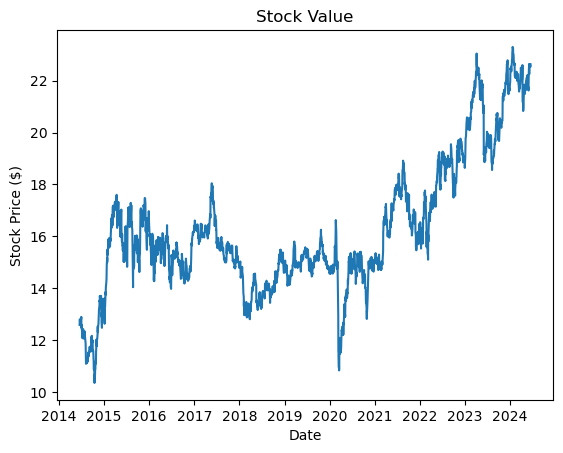

In [77]:
plt.title('Stock Value')
plt.plot(data["Close"])
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.grid(False)

In [78]:
stats = [
    
    ('Mean', data['Close'].mean()),
    ('Std Dev', data['Close'].std()),
    (f"Min (on {data['Close'].idxmin().date()})", data['Close'].min()),
    (f"Max (on {data['Close'].idxmax().date()})", data['Close'].max()),
    ('25% Quantile (Q1)', data['Close'].quantile(0.25)),
    ('Median (Q2)', data['Close'].quantile(0.50)),
    ('75% Quantile (Q3)', data['Close'].quantile(0.75)),
]

# Turn the list into a DataFrame and keep the name 'stats'
stats = pd.DataFrame(stats, columns=['Statistics of Returns', 'Value'])
stats['Value'] = round(stats['Value'],2)
stats


,Statistics of Returns,Value
0,Mean,16.28
1,Std Dev,2.59
2,Min (on 2014-10-16),10.35
3,Max (on 2024-01-22),23.30
4,25% Quantile (Q1),14.77
5,Median (Q2),15.64
6,75% Quantile (Q3),17.48


The log returns are defined as
$$
r_t = ln\left(\frac{P_{t}}{P_{t-1}}\right) = ln(P_{t})-ln(P_{t-1})
$$

In [79]:
logPrices = np.log(np.array(data["Close"]))
data["LogReturn"] = np.log(data['Close']).diff()
data.tail()

,Close,LogReturn
Date,,
2024-06-10,22.610001,0.000885
2024-06-11,22.610001,0.000000
2024-06-12,22.540001,-0.003101
2024-06-13,22.530001,-0.000444
2024-06-14,22.629999,0.004429


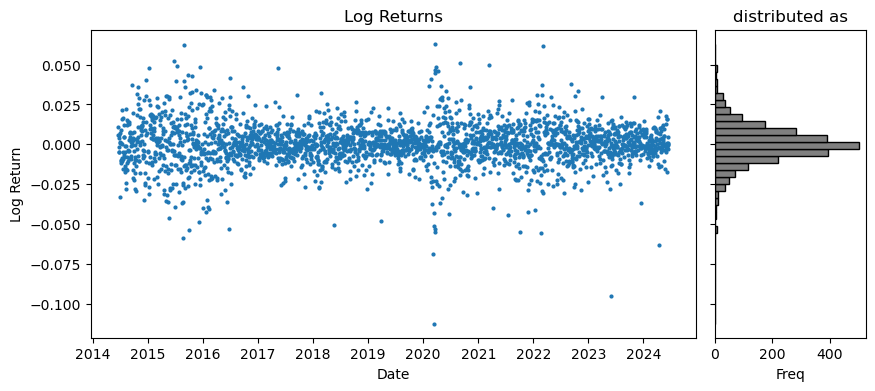

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.05})

ax1.plot(data.index, data['LogReturn'], marker='.', ls='',markersize='4')
ax1.set_title('Log Returns')
ax1.set_xlabel('Date')
ax1.set_ylabel('Log Return')

ax2.set_title('distributed as')
ax2.hist(data['LogReturn'].dropna(), bins=40, orientation='horizontal', color='gray', edgecolor='black',density=False)
ax2.set_xlabel('Freq')
ax2.tick_params(labelleft=False)  # Hide y-axis labels on histogram


plt.show()

In [81]:
logReturns = data['LogReturn'].dropna()
logstats = {
    'Mean': logReturns.mean(),
    'Std': logReturns.std(),
    'Minimum': logReturns.min(),
    'Maximum': logReturns.max(),
    '25% Quantile (Q1)': logReturns.quantile(0.25),
    'Median (Q2)': logReturns.quantile(0.50),
    '75% Quantile (Q3)': logReturns.quantile(0.75),
}

# Convert to DataFrame
pd.DataFrame.from_dict(logstats, orient='index', columns=['Value'])

,Value
Mean,0.000231
Std,0.013379
Minimum,-0.112673
Maximum,0.063141
25% Quantile (Q1),-0.005909
Median (Q2),0.000000
75% Quantile (Q3),0.007092


### 📈 Task 2 – Fit the Black-Scholes Model to `Telecom.csv`

In this task, we estimate the parameters of the **Black-Scholes model** using historical price data from `Telecom.csv`.

---

🧾 **Black-Scholes Model**

The Black-Scholes model assumes the asset price follows the stochastic differential equation (SDE):

$$
dP_t = P_t \left( b\,dt + \sigma\,dW_t \right)
$$

Applying **Itô's Lemma** to the logarithm of the price process, we obtain:

$$
d(\log P_t) = \left(b - \frac{1}{2} \sigma^2 \right) dt + \sigma\, dW_t
$$

---

🔍 **Estimation via Log Returns**

Using a time series of prices $P_t$, we approximate the differential of the log price by the **discrete log return**:

$$
d(\log P_t) \approx r_t = \log(P_{t+1}) - \log(P_t)
$$

From this, we can estimate the model parameters:

- **Volatility (σ)**:
  $$
  \sigma \approx \text{std}(r_t)
  $$

- **Drift (b)**:
  $$
  b \approx \text{mean}(r_t) + \frac{1}{2} \sigma^2
  $$

---

⏱️ Time Units and Annualization

These estimates are computed per trading day. To convert to **annualized values**, use:

- $\sigma_{\text{annual}} = \sigma_{\text{daily}} \cdot \sqrt{252}$
- $b_{\text{annual}} = b_{\text{daily}} \cdot 252$

> 📝 Note: 252 is the typical number of trading days in a year.

---




In [82]:
P0 = np.array(data["Close"])[0]
r = 0.02  # by assumption
sigma = logstats["Std"] * np.sqrt(252)
b = logstats["Mean"] * 252 + 0.5 * sigma * sigma

print('The parameters of the Black-Scholes Model are:')
print(f'Initial Price P0 ($):       {P0:.2f}')
print(f'Interest Rate (annual):    {r:.2%}')
print(f'Volatility σ (annual):      {sigma:.4f}')
print(f'Drift b (annual):               {b:.4f}')

The parameters of the Black-Scholes Model are:
Initial Price P0 ($):       12.59
Interest Rate (annual):    2.00%
Volatility σ (annual):      0.2124
Drift b (annual):               0.0808



### 📘 Task 3 – Bonus Certificates

💡 **What Are Bonus Certificates?**

Bonus Certificates are structured financial products that offer investors participation in the performance of an underlying asset (e.g., a stock or index), while also providing partial downside protection and the possibility of a bonus payment at maturity.

They are popular retail derivatives in Europe and are issued by banks. These products usually combine:

- A **long position** in the underlying (or a portion of it)
- A **short put option** (sold by the investor)
- A **bonus feature** that rewards the investor if a barrier is not breached

---

💰 **Payoff at maturity**

Let:

- $ P_T $: price of the underlying at maturity
- $ H $: barrier level
- $ B $: bonus level (guaranteed payoff if barrier is not touched)

Then the payoff $ \text{Bonus}(T) $ is typically:

$$
\text{Bonus}(T) =
\begin{cases}
\max(B,P_T) & \text{if } P_t > H \text{ for all } t \in [0, T] \\
P_T & \text{if } P_t \leq H \text{ at any time}
\end{cases}
$$

The payoff of a capped bonus certificate is given by:
$$
\text{Bonus}(T,C) = \min(\text{Bonus}(T),C)

$$

This means:

- If the **barrier is never breached**, the investor gets at least the bonus level $ B $.
- If the **barrier is breached**, the investor simply receives the final value $ P_T $, just like holding the underlying asset.
- In both cases, the maximum payoff you can get is $C$, when the **bonus certificate is capped**
-----

🎯 **Why Would an Investor Buy One?**

Investors are drawn to Bonus Certificates for several reasons:

- *Partial downside protection*: as long as the barrier isn't breached, the bonus guarantees a minimum return.
- *Enhanced returns in sideways markets*: if the underlying stagnates but doesn't fall below the barrier, the investor still gets the bonus.

---

⚠️ **Risks to Consider**

While attractive, Bonus Certificates carry important risks:

1. *Barrier breach risk*: if the barrier is touched, protection is lost and the investor participates fully in losses.
2. *Credit risk*: the product is issued by a bank — if the issuer defaults, the protection and return may be worthless.
3. *Liquidity risk*: they may not be easily tradable in the secondary market.



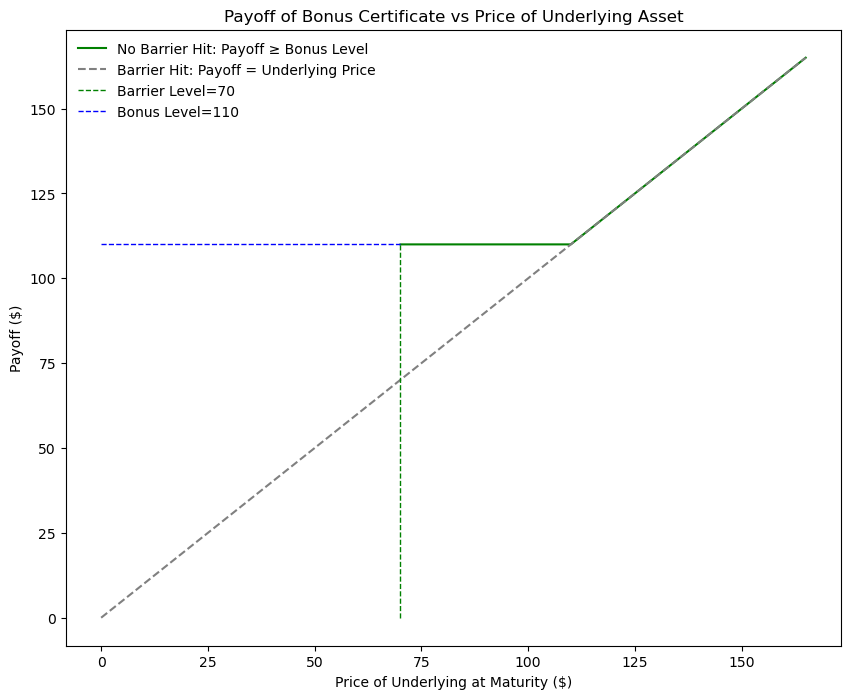

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

P0 = 100
bonuslevel = 110
barrier = 70
assert barrier <= P0 <= bonuslevel

PT = np.linspace(0, 1.5 * bonuslevel, int(10 * bonuslevel))  # fine grid
payoff = np.maximum(PT[PT > barrier], bonuslevel)
underlying = PT
plt.figure(figsize=(10,8))
plt.title("Payoff of Bonus Certificate vs Price of Underlying Asset")
plt.plot(PT[PT > barrier], payoff, color='green', label='No Barrier Hit: Payoff ≥ Bonus Level')
plt.plot(PT, underlying, ls='--', color='grey', label='Barrier Hit: Payoff = Underlying Price')
plt.plot([barrier, barrier], [0, bonuslevel], lw=1, ls='--', color='green', label=f'Barrier Level={barrier}')
plt.plot([0, barrier], [bonuslevel, bonuslevel], lw=1, ls='--', color='blue', label=f'Bonus Level={bonuslevel}')
plt.xlabel('Price of Underlying at Maturity ($)')
plt.ylabel('Payoff ($)')
plt.legend(loc='best',frameon=False)
plt.show()


### 📘 Task 4 – Replicating the Bonus Certificate Payoff

The payoff of a **Bonus Certificate** at maturity $T$ is:

$$
\text{Bonus}(T) = P_T + (B - P_T)^+ \cdot \mathbf{1}_{\{P_t > H \ \forall t \in [0, T]\}}
$$

Where:
- $P_T$: Price of the underlying at maturity  
- $B$: Bonus level  
- $H$: Barrier level  
- $(B - P_T)^+$: Payoff of a put option with strike $B$  
- The indicator ensures the bonus applies only if the barrier is **never breached**

This corresponds to a **portfolio** of:
- A **long position** in the underlying  
- A **long down-and-out put** option (strike $B$, barrier $H$)

---

If the certificate is **capped** at level $C$, the payoff is:

$$
\text{Bonus}(T, C) = \text{Bonus}(T) - (P_T - C)^+
$$

Which introduces:
- A **short vanilla call** with strike $C$

---

🧾 **Summary of Replicating Portfolio**:
- Long underlying ($P_T$)  
- Long down-and-out put (strike $B$, barrier $H$)  
- Short call option (strike $C$, only for capped version)


### 💰 Task 5 – Determine a Fair Price for the Certificates

We compute the fair price of the bonus certificate for market parameters:  
$$
H = 16, \quad B = 16, \quad T = 1 \text{ year}
$$


The fair price corresponds to the **risk-neutral expected discounted payoff**:

$$
\begin{aligned}
\text{Bonus}(0) &= \mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} P_T \right] 
+ \mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} (B - P_T)^+ \cdot \mathbf{1}_{\{P_t > H, \, \forall t \in [0,T]\}} \right] \\
&= P_0 
+ \mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} (P_T - B) \cdot \mathbf{1}_{\{P_t > H, \, \forall t \in [0,T]\}} \right] \\
&\quad 
- \mathbb{E}_{\tilde{\mathbb{Q}}} \left[ e^{-rT} (P_T - B)^+ \cdot \mathbf{1}_{\{P_t > H, \, \forall t \in [0,T]\}} \right] \\
&= P_0 + \text{DOC} - (P_0Q^{(1)} −e^{−r T}BQ^{(2)})
\end{aligned}
$$

where $\text{DOC}$ represent a down-and-out call option with strike $B$ and barrier $H$, and $Q^{(1)}$ and $Q^{(2)}$ are given by 

$$
\begin{aligned}
Q^{(1)} &= \mathcal{N}\left(\frac{\log \frac{P_0}{H} + \left(r + \frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right) - \exp\left(-\frac{2\left(r + \frac{\sigma^2}{2}\right) \log \frac{P_0}{H}}{\sigma^2}\right) \mathcal{N}\left(\frac{-\log \frac{P_0}{H} + \left(r + \frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right) \\
Q^{(2)} &= \mathcal{N}\left(\frac{\log \frac{P_0}{H} + \left(r - \frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right) - \exp\left(-\frac{2\left(r - \frac{\sigma^2}{2}\right) \log \frac{P_0}{H}}{\sigma^2}\right) \mathcal{N}\left(\frac{-\log \frac{P_0}{H} + \left(r - \frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}\right)
\end{aligned}
$$

Here, $\mathcal{N}(\cdot)$ is the standard normal cumulative distribution function.

---

The fair price of the **capped bonus certificate** can be computed by subtracting the price of a call option with strike $C$:

$$
\text{Bonus}(0,C) = \text{Bonus}(0) - \text{Call}(0,C)
$$

As expected, the capped bonus has a lower fair price due to its limited upside.

---

> ⚠️ **Note:** The above formula is a work in progress and may require refinement to fully capture the payoff structure. Further derivations or numerical checks are advised.


In [84]:
data.head()

,Close,LogReturn
Date,,
2014-06-17,12.585,NaN
2014-06-18,12.660,0.005942
2014-06-19,12.800,0.010998
2014-06-20,12.735,-0.005091
2014-06-23,12.675,-0.004723


In [85]:
P0 = data["Close"][pd.to_datetime("2024-06-14")]
H = 16
B = 24
C = 50
T = 1
print(f'The parameters for the pricing are')
print(f'Maturity: {T} year(s)')
print(f'Initial Price: {P0:.3f}')
print(f'Interest rate: {r}')
print(f'Volatility: {sigma:.3f}')
print(f'Barrier H: {H}')
print(f'Bonus Level B: {B}')
print(f'Capped Payoff C: {C}')



The parameters for the pricing are
Maturity: 1 year(s)
Initial Price: 22.630
Interest rate: 0.02
Volatility: 0.212
Barrier H: 16
Bonus Level B: 24
Capped Payoff C: 50


In [143]:
from scipy.stats import norm
# incomplete Q1 and Q2 are not sufficient to calculate d&o put

def Call(P0,K,r,sigma,T):
    sigma2 = sigma * sigma          # sigma-squared makes the formula cleaner
    constant1 = (np.log(P0/K) + (r+0.5*sigma2)*T) / (sigma*np.sqrt(T))
    constant2 = constant1 - sigma * np.sqrt(T)
    Call = P0 * norm.cdf(constant1) - K * np.exp(-r*T) * norm.cdf(constant2)
    return Call

def DownAndOutCall(P0,K,H,r,sigma,T):
    if(P0<H): return 0
    sigma2 = sigma * sigma          # sigma-squared makes the formula cleaner
    constant1 = (np.log((H*H)/(P0*K)) + (r+0.5*sigma2)*T) / (sigma*np.sqrt(T))
    constant2 = constant1 - sigma * np.sqrt(T)
    lam = r - 0.5*sigma2
    KnockOutDiscount = P0 * np.pow( H/P0, 2+2*lam/sigma2) * norm.cdf(constant1) - K * np.exp(-r*T) * np.pow(H/P0,2*lam/sigma2) * norm.cdf(constant2)
    return Call(P0,K,r,sigma,T) - KnockOutDiscount

def Q1(P0, H, r, sigma, T):
    log_term = np.log(P0 / H)
    drift = r + 0.5 * sigma**2
    denom = sigma * np.sqrt(T)

    term1 = norm.cdf((log_term + drift * T) / denom)
    
    exponent = - (2 * drift * log_term) / sigma**2
    term2 = np.exp(exponent) * norm.cdf((-log_term + drift * T) / denom)

    return term1 - term2

def Q2(P0, H, r, sigma, T):
    log_term = np.log(P0 / H)
    drift = r - 0.5 * sigma**2
    denom = sigma * np.sqrt(T)

    term1 = norm.cdf((log_term + drift * T) / denom)
    
    exponent = - (2 * drift * log_term) / sigma**2
    term2 = np.exp(exponent) * norm.cdf((-log_term + drift * T) / denom)

    return term1 - term2

def DownAndOutPut(P0,K,H,r,sigma,T):
    if(P0<H): return 0
    q1 = Q1(P0,H,r,sigma,T)
    q2 = Q2(P0,H,r,sigma,T)
    doc = DownAndOutCall(P0,K,H,r,sigma,T)
    dop = doc - (P0*q1 - np.exp(-r*T)*K*q2)
    return dop

def BonusCertificate(P0,B,H,r,sigma,T,Capped=None):

    if(Capped==None):
        bonus =  P0 + DownAndOutPut(P0,B,H,r,sigma,T)
    elif(B<Capped):
        bonus =  P0 + DownAndOutPut(P0,B,H,r,sigma,T) - Call(P0,Capped,r,sigma,T)
    else:
        print('CAP level must be GREATER than BONUS level')
        return None
    
    results = {
    "Maturity (years)": T,
    "Initial Price": P0,
    "Interest Rate": r,
    "Volatility": sigma,
    "Barrier H": H,
    "Bonus Level B": B,
    "Capped Payoff C": Capped,
    "Bonus Price": bonus
    }
    return results

P0 = data["Close"][pd.to_datetime("2024-06-14")]
H = 16
B = 24
C = None
T = 1
results = BonusCertificate(P0,B,H,r,sigma,T,Capped=C)
pd.DataFrame([results]).T



,0
Maturity (years),1
Initial Price,22.630
Interest Rate,0.020
Volatility,0.212
Barrier H,16
Bonus Level B,24
Capped Payoff C,None
Bonus Price,24.251


### Task 6: Monte Carlo Pricing 🎲💵

To approximate the risk-neutral expected payoff, we use the **law of large numbers** and simulate many paths of the underlying price process $P_t$ under the **risk-neutral measure** $\tilde{\mathbb{Q}}$.

According to the Black-Scholes model, the dynamics are:

$$
P_t = P_0 \, e^{\left(r - \frac{1}{2}\sigma^2\right) t + \sigma \tilde{W}_t}
$$

where $\tilde{W}_t$ is a Brownian motion under $\tilde{\mathbb{Q}}$.

We simulate multiple paths and compute the payoff at maturity as

$$
P_T + (B - P_T)^+ \cdot \mathbf{1}_{\{P_t > H, \ \forall t \in [0,T]\}}
$$

which includes the underlying payoff plus the bonus payoff if the barrier $H$ is never breached.


21.239691166508003
24.43210680932374
25.50508070423706
24.874833742031285
14.91664816024141


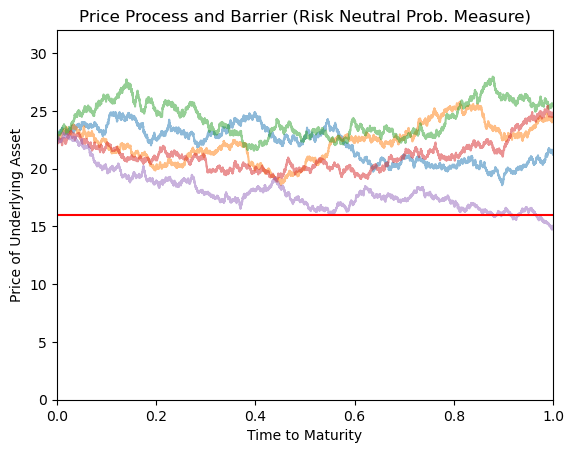

In [ ]:
def BM(T,n):
    """
    Simulate a Brownian motion path.

    Parameters
    ----------
    T : float
        The time horizon.
    n : int
        The number of time steps.
    """
    dt = T / n
    t = np.linspace(0,T,n+1)
    W = np.zeros(n+1)
    W[1:] = np.cumsum(np.sqrt(dt) * np.random.normal(size=n))
    return t, W

def PriceProcess(T,P0,sigma,r,n=10_000):
    """    
    Simulate a Geometric Brownian motion path.

    Parameters
    ----------
    T : float
        The time horizon.
    n : int
        The number of time steps.
    """
    dt = T / n
    t = np.linspace(0,T,n+1)
    X = np.zeros(n+1)
    X[1:] = np.cumsum(
        (r-0.5*sigma*sigma) * dt 
        + sigma * np.sqrt(dt) * np.random.standard_normal(size=n)
    )
    P = P0 * np.exp(X)
    return t,P

for _ in range(5):
    t,P = PriceProcess(T=T,P0=P0,sigma=sigma,r=r)
    plt.plot(t,P,alpha=0.5)

plt.plot([0,1],[H,H],color='red')
plt.xlim((0,1))
plt.ylim(0,2 * H)
plt.title('Price Process and Barrier (Risk Neutral Prob. Measure)')
plt.xlabel('Time to Maturity')
plt.ylabel('Price of Underlying Asset')
plt.show()


In [130]:
def BonusPayoff(Pt,H,B,Capped=None):
    PT = Pt[-1]
    if np.min(Pt)>H:
        payoff = (PT + max(0,B-PT),False)
    else:
        payoff = (PT,True)

    if(Capped==None): return payoff
    # Only for Capped Bonus Certificates
    elif(B<Capped):
        payoff= (min(payoff[0], Capped), payoff[1])
        return payoff
    else:
        print('CAP level must be GREATER than BONUS level')
        return None

for _ in range(10):
    _ ,Pt = PriceProcess(T,P0,sigma,r)
    payoff, hit = BonusPayoff(Pt,H,B,Capped=None)
    if (hit): print(f'Bonus Payoff: {payoff:.3f} Barrier Hit')
    else: print(f'Bonus Payoff: {payoff:.3f}')
    

Bonus Payoff: 25.845
Bonus Payoff: 19.426 Barrier Hit
Bonus Payoff: 24.000
Bonus Payoff: 24.000
Bonus Payoff: 24.000
Bonus Payoff: 24.000
Bonus Payoff: 24.000
Bonus Payoff: 11.563 Barrier Hit
Bonus Payoff: 26.747
Bonus Payoff: 25.625


In [136]:
from tqdm import tqdm
np.random.seed(33)

MT_steps = int(1_000_000)
def MTBonus(T,P0,r,sigma,B,H,Capped=None,steps=MT_steps):
    disc = np.exp(-r*T)
    disc_payoffs = []
    for _ in tqdm(range(steps)):
        _,Pt = PriceProcess(T,P0,sigma,r)
        payoff,hit = BonusPayoff(Pt,H,B,Capped)
        disc_payoffs.append(disc * payoff)
    fairPrice = np.mean(disc_payoffs)
    results = {
    "Maturity (years)": T,
    "Initial Price": P0,
    "Interest Rate": r,
    "Volatility": sigma,
    "Barrier H": H,
    "Bonus Level B": B,
    "Capped Payoff C": Capped,
    "Bonus Price": fairPrice
    }
    return results

montecarloResults = MTBonus(T,P0,r,sigma,B,H,Capped=None,steps=MT_steps)
pd.DataFrame([montecarloResults]).T


100%|██████████| 1000000/1000000 [02:45<00:00, 6053.27it/s]


,0
Maturity (years),1
Initial Price,22.630
Interest Rate,0.020
Volatility,0.212
Barrier H,16
Bonus Level B,24
Capped Payoff C,None
Bonus Price,24.256


In [138]:
theoreticalBonusPrice = results["Bonus Price"]
montecarloBonusPrice = montecarloResults["Bonus Price"]
relative_error = abs(theoreticalBonusPrice - montecarloBonusPrice) / theoreticalBonusPrice * 100  # in %

print(f"Theoretical Bonus Price: ${theoreticalBonusPrice:.3f}")
print(f"Monte Carlo Bonus Price: ${montecarloBonusPrice:.3f}")
print(f"Relative Error: {relative_error:.2f}%")

Theoretical Bonus Price: $24.251
Monte Carlo Bonus Price: $24.256
Relative Error: 0.02%


### Task 7: Simulation under the Physical Measure 📊⚖️

Simulate the underlying asset and the certificate payoff under the **physical (real-world) probability measure**. 

Compare the distributions of the payoff and the underlying asset by computing their **mean**, **variance**, **skewness**, **kurtosis**, and the **5% quantile** (also known as the **Value-at-Risk**). 

What do you observe from these statistics?

According to the Black-Scholes model, under the real-world measure $\mathbb{Q}$, the price process $P_t$ follows:

$$
P_t = P_0 \, e^{\left(b - \frac{1}{2}\sigma^2\right) t - \sigma W_t}
$$

where:

- $b$ is the drift of the underlying,
- $\sigma$ is its volatility,
- $W_t$ is a Brownian motion under the real-world measure $\mathbb{Q}$.


In [139]:
PT = []
payoffs = []
for _ in tqdm(range(1_000_000)):
    _,Pt = PriceProcess(T,P0,sigma,b)
    PT.append(Pt[-1])
    payoff,hit = BonusPayoff(Pt,H,B,Capped=None)
    payoffs.append(payoff)

PT = np.array(PT)
payoffs = np.array(payoffs)

def compute_stats(X: np.array):
    mean = np.mean(X)
    std = np.std(X)
    return {
        'mean': mean,
        'variance': np.var(X),
        'skewness': np.mean(((X - mean) / std)**3),
        'kurtosis': np.mean(((X - mean) / std)**4),
        '5% quantile (VaR)': np.quantile(X, 0.05)
    }

pd.DataFrame([compute_stats(PT),compute_stats(payoffs)],
             index=['Underlying Price at T','Bonus Certificate Payoff']).T







100%|██████████| 1000000/1000000 [02:45<00:00, 6047.94it/s]


,Underlying Price at T,Bonus Certificate Payoff
mean,24.535,25.849
variance,27.772,19.070
skewness,0.648,0.661
kurtosis,3.745,5.991
5% quantile (VaR),16.903,17.674


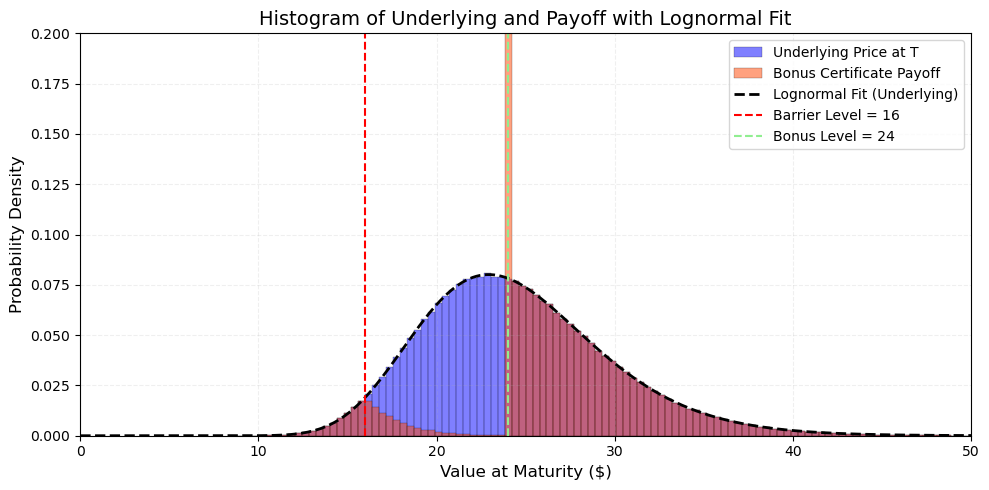

In [140]:
from scipy.stats import lognorm

# Fit a lognormal distribution to the underlying
s = sigma
scale = P0 * np.exp(b - 0.5 * sigma * sigma * T)
x = np.linspace(0.01, 50, 1000)
y = lognorm.pdf(x, s=s, scale=scale)

plt.figure(figsize=(10, 5))

# Plot histograms
plt.hist(PT, bins=150, density=True, alpha=0.5, color='blue',
         edgecolor='black', linewidth=0.3, label='Underlying Price at T')

plt.hist(payoffs, bins=150, density=True, alpha=0.5, color='orangered',
         edgecolor='black', linewidth=0.3, label='Bonus Certificate Payoff')

# Plot fitted lognormal PDF
plt.plot(x, y, color='black', linestyle='--', linewidth=2,
         label='Lognormal Fit (Underlying)')

# Add vertical reference lines
plt.axvline(x=H, color='red', linestyle='--', linewidth=1.5, alpha=1, label=f'Barrier Level = {H}')
plt.axvline(x=B, color='lightgreen', linestyle='--', linewidth=1.5, alpha=1, label=f'Bonus Level = {B}')

# Labels, legend, and layout
plt.title('Histogram of Underlying and Payoff with Lognormal Fit', fontsize=14)
plt.xlabel('Value at Maturity ($)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.xlim(0, 50)
plt.ylim(0, 0.2)
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

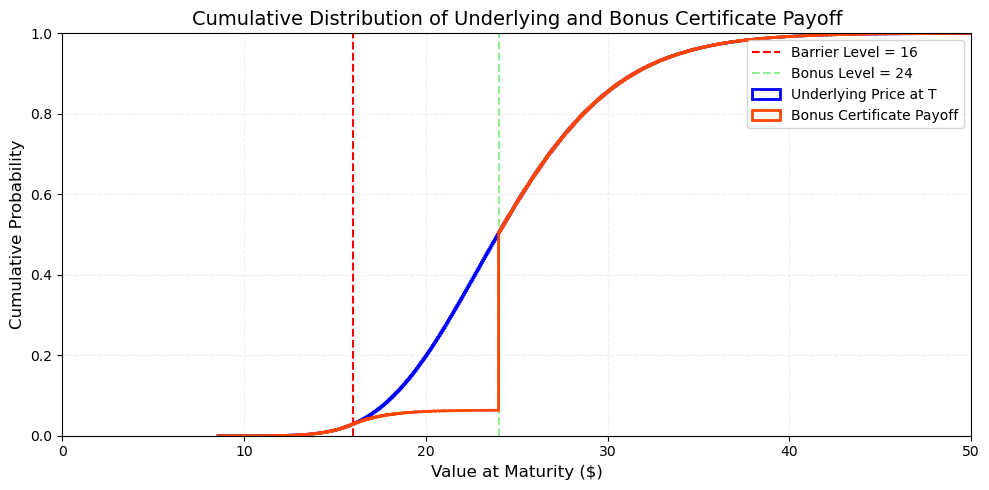

In [141]:
plt.figure(figsize=(10, 5))

# Barrier and bonus level reference lines
plt.axvline(x=H, color='red', linestyle='--', label=f'Barrier Level = {H}')
plt.axvline(x=B, color='lightgreen', linestyle='--', label=f'Bonus Level = {B}')

plt.hist(PT, bins=1000, density=True, cumulative=True,
         histtype='step', color='blue', linewidth=2,
         label='Underlying Price at T')

plt.hist(payoffs, bins=1000, density=True, cumulative=True,
         histtype='step', color='orangered', linewidth=2,
         label='Bonus Certificate Payoff')

plt.title('Cumulative Distribution of Underlying and Bonus Certificate Payoff', fontsize=14)
plt.xlabel('Value at Maturity ($)', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.xlim(0, 50)
plt.ylim(0, 1)

# Legend and grid
plt.legend(frameon=True)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()